In [1]:
import requests as rq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from nltk.metrics.distance import jaccard_distance

C:\Users\a4lu9\AppData\Local\Temp\ipykernel_30392\892217844.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Part 1. Define function for querying datamuse.

In [2]:
def query_datamuse(word, n=100):
    query = "https://api.datamuse.com/words?ml={}&max={}".format(word, n)
    response = rq.get(query)
    results = []
    for obj in response.json(): 
        results.append(obj["word"])
    return results

In [3]:
#Load datasets 
mc = pd.read_csv("data/mc.csv", header=0, names=["word1", "word2", "score"], sep=";")
rg = pd.read_csv("data/rg.csv", header=0, names=["word1", "word2", "score"], sep=";")
wordsim = pd.read_csv("data/wordsim.csv", header=0, names=["word1", "word2", "score"], sep=";")

### Part 2. Define functions for calculating jaccard similarity from dataset.

In [4]:
def jaccard_similarity(set1, set2): 
    return 1 - jaccard_distance(set1, set2)

def datamuse_similarity(X, Y, n=100):
    words1 = query_datamuse(X, n=n)
    words2 = query_datamuse(Y, n=n)    
    return jaccard_similarity(set(words1), set(words2))

def calculate_similarities(df, n): 
    words1 = df["word1"].tolist()
    words2 = df["word2"].tolist()
    scores = df["score"].tolist()

    sim_values = []
    for w1, w2 in zip(words1, words2): 
        sim_values.append(datamuse_similarity(w1, w2, n=n))
        
    p = stats.pearsonr(sim_values, scores)
    return p

In [5]:
calculate_similarities(mc, 100)

PearsonRResult(statistic=0.6197982041050106, pvalue=0.00033604739037884374)

### Find the N with highest Pearson correlation coefficient score.

In [6]:
def find_best_n(df): 
    d = {
        "n": [],
        "statistics": [],
        "pvalues": []
    }
    stats = []
    pvals = []
    for n in range(100, 1000, 100): 
        print("N: {}".format(n))
        p = calculate_similarities(mc, n)
        d["n"].append(n)
        d["statistics"].append(p.statistic)
        d["pvalues"].append(p.pvalue)
    
    return d

d = find_best_n(mc)
df = pd.DataFrame.from_dict(d)

N: 100
N: 200
N: 300
N: 400
N: 500
N: 600
N: 700
N: 800
N: 900


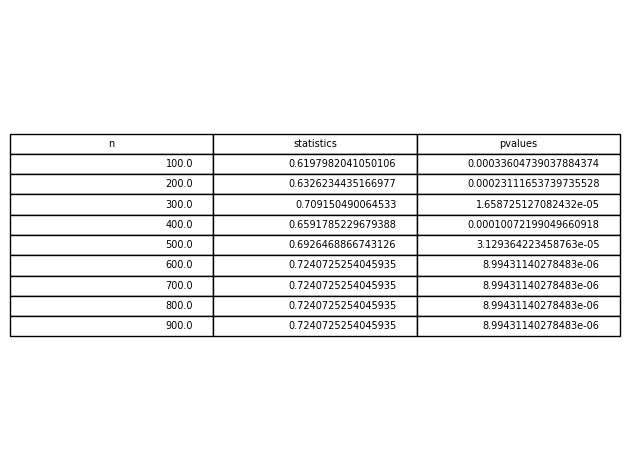

In [7]:
fig, ax = plt.subplots()

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=df.values, colLabels=df.columns, loc='center')
fig.tight_layout()
plt.show()

In [8]:
# Get the N value with highest Pearson correlation coefficient score
max_id = df['statistics'].idxmax()
N = int(df.iloc[max_id]["n"])
print(N)

600


### Calculate correlation coefficients for all datasets.

In [9]:
p_mc = calculate_similarities(mc, N)
p_rg = calculate_similarities(rg, N)
p_wordsim = calculate_similarities(wordsim, N)
print(p_mc)
print(p_rg)
print(p_wordsim)

PearsonRResult(statistic=0.7240725254045935, pvalue=8.99431140278483e-06)
PearsonRResult(statistic=0.7850157130429563, pvalue=1.6236618035026168e-14)
PearsonRResult(statistic=0.49022656405756, pvalue=1.1105676505687938e-22)


# Part 3 - Apply the method in part 2 on sentence level

In [10]:
# get sentence bag of similartities words

def get_bag_of_words(sentence): 
    words = sentence.split(" ")
    bag = set(words)
    for word in words: 
        bag = bag.union(set(query_datamuse(word, n=N)))
    return bag

def get_sentence_similarity(sentence1, sentence2):
    bag1 = get_bag_of_words(sentence1)
    bag2 = get_bag_of_words(sentence2)
    return jaccard_similarity(bag1, bag2)

# Part 4

In [45]:
sentence_pairs_list = [
    ["Today is quite hot for a winter.", "Never is warm in winter."],
    ["The car is running fast but has some troubles recently.", "Toyota cars are recalled for a fault."],
    ["The teacher cannot do it again and never again.", "Teacher has been prohibited from this task."],
]

In [46]:
results = []
for pair in sentence_pairs_list: 
    results.append(get_sentence_similarity(pair[0], pair[1]))

# create a table
d = {
    "sentence1": [x[0] for x in sentence_pairs_list],
    "sentence2": [x[1] for x in sentence_pairs_list],
    "similarity": results
}

df = pd.DataFrame.from_dict(d)
df

,sentence1,sentence2,similarity
0,Today is quite hot for a winter.,Never is warm in winter.,0.141104
1,The car is running fast but has some troubles ...,Toyota cars are recalled for a fault.,0.078636
2,The teacher cannot do it again and never again.,Teacher has been prohibited from this task.,0.175842


In [47]:
def get_boosted_sentence_similarity(sentence1, sentence2):
    words2 = sentence2.split(" ")
    lw = len(words2)
    
    bag1 = get_bag_of_words(sentence1)
    r = ""
    i = lw
    for w in words2: 
        if w not in bag1: 
            r += w + " "   
            i -= 1
    bag2 = get_bag_of_words(r)
    return ((lw - i) * jaccard_similarity(bag1, bag2) + i)/lw


In [48]:
results = []
for pair in sentence_pairs_list: 
    results.append(get_boosted_sentence_similarity(pair[0], pair[1]))

# create a table
d = {
    "sentence1": [x[0] for x in sentence_pairs_list],
    "sentence2": [x[1] for x in sentence_pairs_list],
    "similarity": results
}

df = pd.DataFrame.from_dict(d)
df

,sentence1,sentence2,similarity
0,Today is quite hot for a winter.,Never is warm in winter.,0.624797
1,The car is running fast but has some troubles ...,Toyota cars are recalled for a fault.,0.325626
2,The teacher cannot do it again and never again.,Teacher has been prohibited from this task.,0.401865
